An implementation of Wolff algorithm with simulated annealing to the 2D Ising spin glass

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# fix random seed
np.random.seed(1234)

In [529]:
# set the size of the model N x N and initial spins
N = 25
spins_initial = np.random.choice([-1,1], (N,N))
print(spins_initial.sum())
print(spins_initial.shape)

# fix time-steps
burn = 1500
evaluation = 2500
time_steps = burn + evaluation

13
(25, 25)


##### Interactions
- up[i, j] = down[i-1, j]
- left[i, j] = right[i, j+1]
- up[0, j] = 0
- down[N-1, j] = 0
- left[i, 0] = 0
- left[i, N-1] = 0

In [530]:
# Initialize interaction arrays: there are four arrays - up, down, left, right neighbours of a site
up, down, left, right = np.zeros((N, N)), np.zeros((N, N)), np.zeros((N, N)), np.zeros((N, N))

# Use J = 1 so graphs are easier to generate
up[1:N, :] = 1
down[0:N-1, :] = up[1:N, :]
left[:, 1:N] = 1
right[:, 0:N-1] = left[:, 1:N]

In [531]:
print(up.sum(axis=0))
print(down.sum(axis=0))
print(left.sum(axis=1))
print(right.sum(axis=1))

[24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24.
 24. 24. 24. 24. 24. 24. 24.]
[24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24.
 24. 24. 24. 24. 24. 24. 24.]
[24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24.
 24. 24. 24. 24. 24. 24. 24.]
[24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24.
 24. 24. 24. 24. 24. 24. 24.]


In [532]:
# create function to find neighbor sites
def nbr_udlr(s_site, s_array):
    n = s_array.shape[0]
    i = s_site[0]
    j = s_site[1]
    
    if i == 0:
        up_site = 0
        down_site = [i+1,j]
    elif i == n-1:
        up_site = [i-1, j]
        down_site = 0
    else: 
        up_site = [i-1, j]
        down_site = [i+1, j]
    
    if j == 0:
        left_site = 0
        right_site = [i, j+1]
    elif j == n-1:
        left_site = [i, j-1]
        right_site = 0
    else:
        left_site = [i, j-1]
        right_site = [i, j+1]
        
    return [up_site, down_site, left_site, right_site]

# create function to return interaction strength
def  int_strength(s_site, udlr, up_array, down_array, left_array, right_array):
    if udlr == 0:
        return up_array[s_site[0], s_site[1]]
    if udlr == 1:
        return down_array[s_site[0], s_site[1]]
    if udlr == 2:
        return left_array[s_site[0], s_site[1]]
    if udlr == 3:
        return right_array[s_site[0], s_site[1]]

def energy_calc(s_array, up_array, down_array, left_array, right_array):
    _N = s_array.shape[0]
    energy = 0

    # find all the values of the neighbors
    for i in range(_N):
        for j in range(_N):
            if i == 0:
                up_nbr = 0
                down_nbr = s_array[i+1,j]
            elif i == N-1:
                up_nbr = s_array[i-1,j]
                down_nbr = 0
            else:
                up_nbr = s_array[i-1,j]
                down_nbr = s_array[i+1,j]
            if j == 0:
                left_nbr = 0
                right_nbr = s_array[i,j+1]
            elif j == N-1:
                left_nbr = s_array[i,j-1]
                right_nbr = 0
            else:
                left_nbr = s_array[i,j-1]
                right_nbr = s_array[i,j+1]
        
            energy += s_array[i,j]*(up_array[i,j]*up_nbr + down_array[i,j]*down_nbr + left_array[i,j]*left_nbr + right_array[i,j]*right_nbr)
    return -energy/2 # each site is calculated twice

In [427]:
def wolff_step(bt, s_array, up_array, down_array, left_array, right_array):
    _N = s_array.shape[0]
    initial_site = np.random.choice(_N, 2) # randomly select a site
    initial_site = [initial_site[0], initial_site[1]]
    old_spin = s_array[initial_site[0], initial_site[1]]
    cluster = [initial_site]
    stack = [initial_site]
    
    while stack != []:
        site = stack[np.random.choice(len(stack))]
       
        # Cycle neigbours
        nbr = nbr_udlr(site, s_array)
        for i in range(4):
            nbr_live = nbr[i]
            if nbr_live == 0:
                continue
            nbr_spin = s_array[nbr_live[0], nbr_live[1]]
            if nbr_spin == old_spin:
                if nbr_live not in cluster:
                    p = 1 - np.exp(-2*bt*int_strength(site, i, up_array, down_array, left_array, right_array))
                    if np.random.random() < p:
                        cluster.append(nbr_live)
                        stack.append(nbr_live)
        stack.remove(site)
    
    for site in cluster:
        s_array[site[0], site[1]] *= -1
    return s_array

In [358]:
# Critical temperature
Tc = 2/(np.log(1 + np.sqrt(2)))
Tc

2.269185314213022

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
-388.0


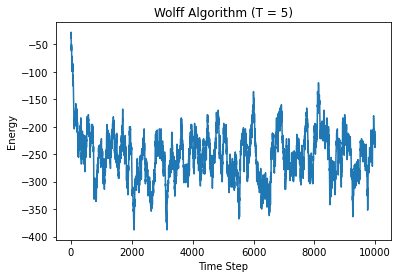

In [359]:
iter = 10000
spins = spins_initial.copy()
T = 5
beta = 1/T
E1 = np.zeros(iter)
for i in range(iter):
    spins = wolff_step(beta, spins, up, down, left, right)
    E1[i] = energy_calc(spins, up, down, left, right)
    if i % 1000 == 0:
        print(i)
print(E1.min())

plt.rcParams["figure.figsize"] = (6,4)
x = np.linspace(1, iter, iter)
plt.plot(E1)
plt.xlabel('Time Step')
plt.ylabel('Energy')
plt.title('Wolff Algorithm (T = 5)')
plt.show()

0
1000
2000
3000
4000
5000
-970.0


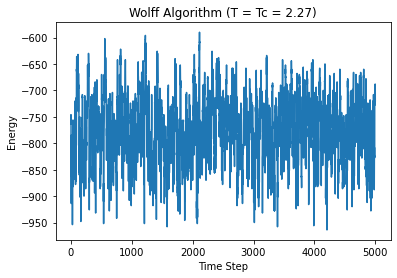

In [360]:
iter = 6000
spins = spins_initial.copy()
T = Tc
beta = 1/T
E2 = np.zeros(iter)
for i in range(iter):
    spins = wolff_step(beta, spins, up, down, left, right)
    E2[i] = energy_calc(spins, up, down, left, right)
    if i % 1000 == 0:
        print(i)
print(E2.min())

x = np.linspace(1, iter-1000, iter-1000)
plt.plot(x, E2[1000:])
plt.xlabel('Time Step')
plt.ylabel('Energy')
plt.title('Wolff Algorithm (T = Tc = 2.27)')
plt.show()

0
100
200
300
400
500
600
700
800
900
1000
-1200.0


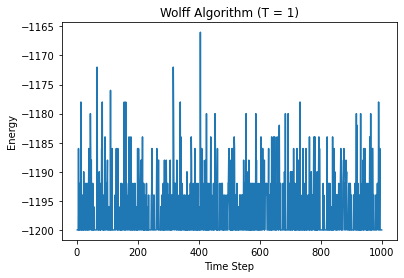

In [361]:
iter = 1100
spins = spins_initial.copy()
T = 1
beta = 1/T
E3 = np.zeros(iter)
for i in range(iter):
    spins = wolff_step(beta, spins, up, down, left, right)
    E3[i] = energy_calc(spins, up, down, left, right)
    if i % 100 == 0:
        print(i)
print(E3.min())

x = np.linspace(1, iter-100, iter-100)
plt.plot(x, E3[100:])
plt.xlabel('Time Step')
plt.ylabel('Energy')
plt.title('Wolff Algorithm (T = 1)')
plt.show()

## End

In [80]:
###### Main Code
# Create useful constants
N1 = evaluation * N * N
N2 = evaluation * evaluation * N * N

# Define temp ranges
temp_steps = 100
temp_min = 1
temp_max = 5

temp_array = np.linspace(temp_min, temp_max, num=temp_steps)
M = np.zeros(temp_steps)
E = np.zeros(temp_steps)
C = np.zeros(temp_steps)
X = np.zeros(temp_steps)

for t in range(temp_steps):
    spins = spins_initial.copy()
    M1 = 0
    M2 = 0
    E1 = 0
    E2 = 0
    beta = 1/temp_array[t]
    for i in range(time_steps):
        spins = wolff_step(beta, spins, up, down, left, right)
        if i > burn:
            mag_tmp = abs(spins.sum())
            M1 += mag_tmp
            M2 += mag_tmp ** 2
            energy_tmp = energy_calc(spins, up, down, left, right)
            E1 += energy_tmp
            E2 += energy_tmp ** 2   

        M[t] = M1 / N1
        E[t] = E1 / N1
        C[t] = (E2/N1 - E1**2/N2) * beta ** 2
        X[t] = (M2/N1 - M1**2/N2) * beta

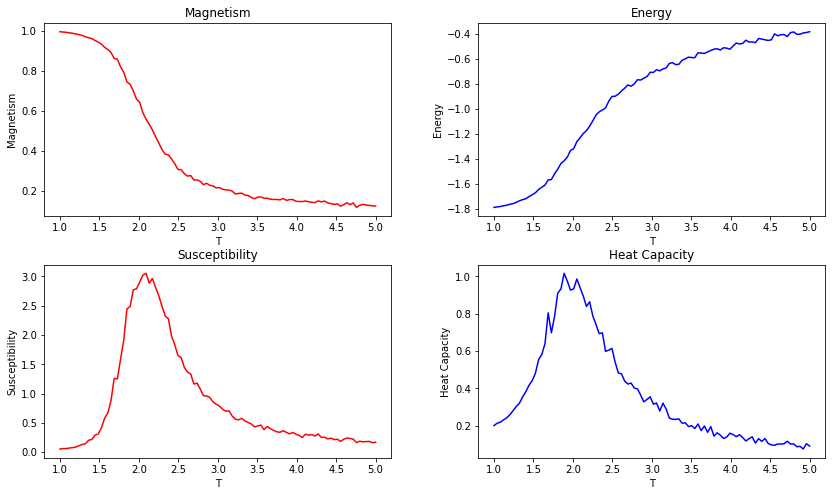

In [129]:
# Create plots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14,8), gridspec_kw={'hspace': 0.25, 'wspace': 0.25})

axs[0, 0].plot(temp_array, M, color='Red')
axs[0, 0].set_title("Magnetism")
axs[0, 0].set(xlabel="T", ylabel="Magnetism")

axs[0, 1].plot(temp_array, E, color='Blue')
axs[0, 1].set_title("Energy")
axs[0, 1].set(xlabel="T", ylabel="Energy")

axs[1, 0].plot(temp_array, X, color='Red')
axs[1, 0].set_title("Susceptibility")
axs[1, 0].set(xlabel="T", ylabel="Susceptibility")

axs[1, 1].plot(temp_array, C, color='Blue')
axs[1, 1].set_title("Heat Capacity")
axs[1, 1].set(xlabel="T", ylabel="Heat Capacity")

plt.show()